In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score


In [77]:
# Load dataset
df = pd.read_excel('Cleaned_dataset_stability.xlsx')
print(" File loaded")

# One-hot encode the categorical composition feature
df_encoded = pd.get_dummies(df, columns=['Perovskite_composition_long_form'])
df_encoded.columns = df_encoded.columns.str.lstrip('_')

# Split into features (X) and target (y)
X = df_encoded.drop(['Stability_PCE_T80'], axis=1)
y = df_encoded[['Stability_PCE_T80']]  # Keep as DataFrame for shape consistency

feature_names = X.columns.tolist()  # Store for plotting


 File loaded


In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(" Data split: ", X_train.shape, y_train.shape)


 Data split:  (1084, 34) (1084, 1)


In [81]:
# Define and train RF model
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train.values.ravel())  # Flatten y
print(" Model trained")


 Model trained


In [83]:
rf_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)


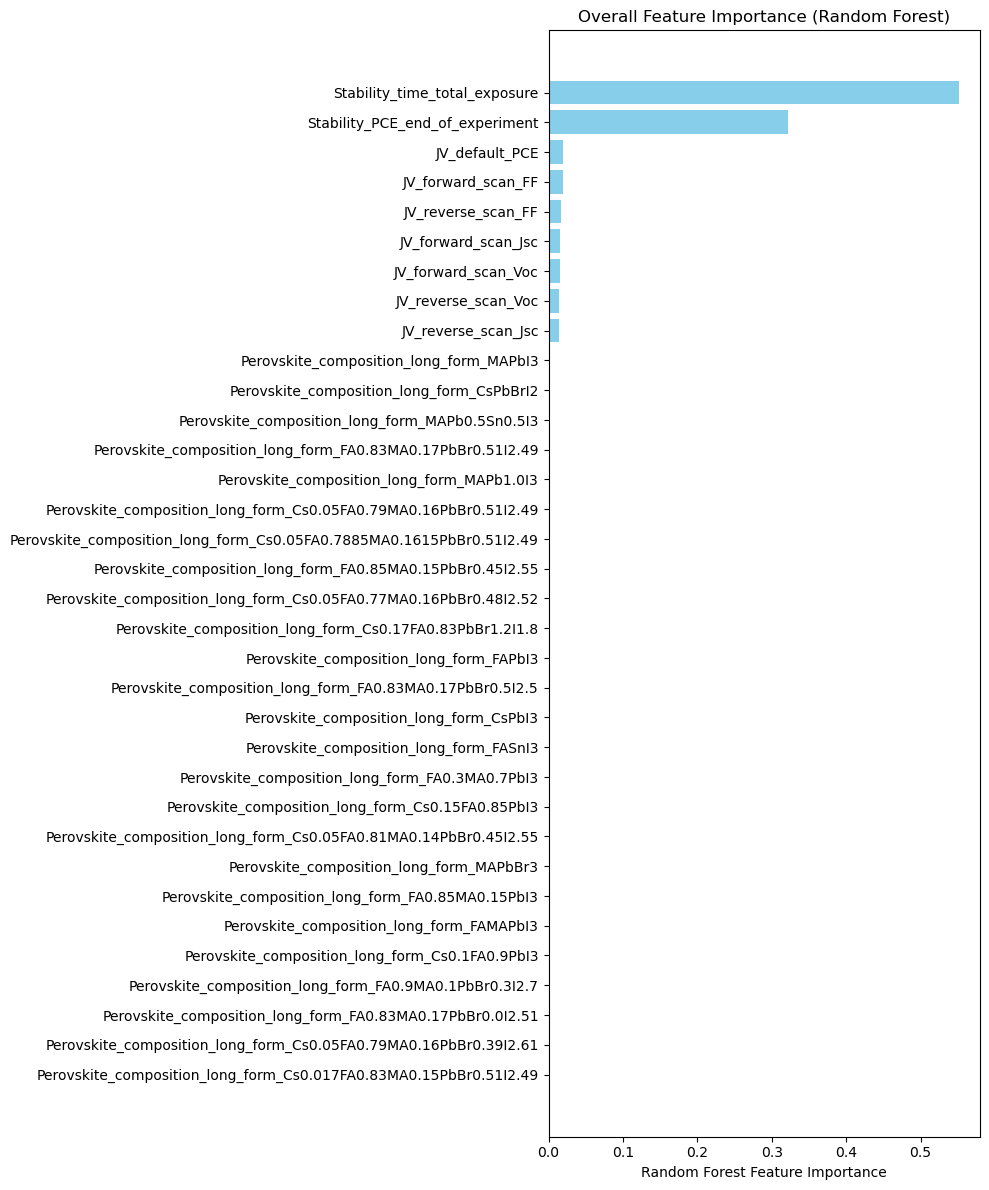

In [85]:
plt.figure(figsize=(10, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Random Forest Feature Importance')
plt.title('Overall Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [87]:
composition_features = [feat for feat in feature_names if 'Perovskite_composition' in feat or 'comp' in feat.lower()]

composition_importance_df = importance_df[importance_df['Feature'].isin(composition_features)]
composition_importance_df = composition_importance_df.sort_values(by='Importance', ascending=False)


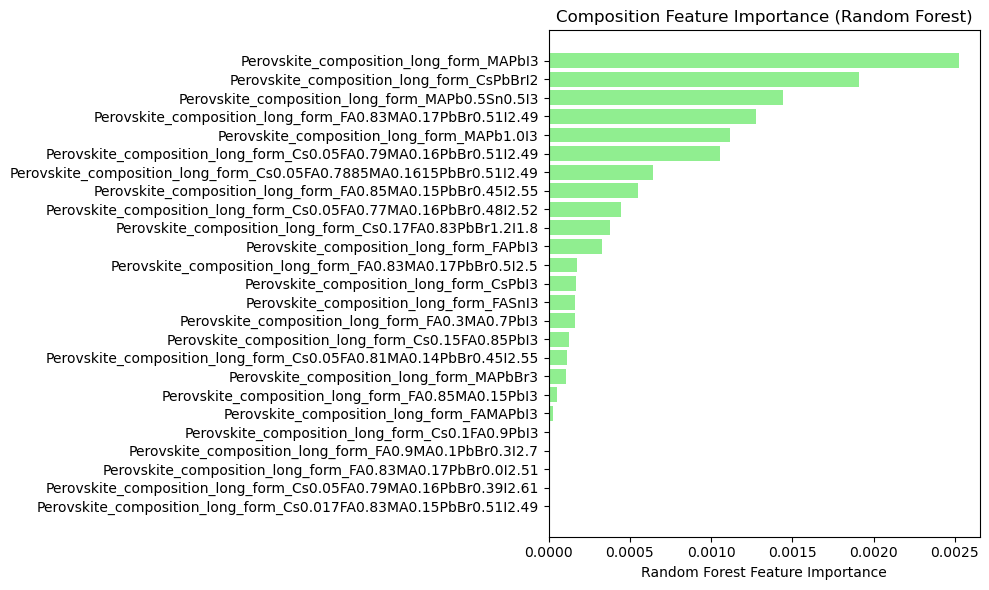

In [89]:
if not composition_importance_df.empty:
    plt.figure(figsize=(10, 6))
    plt.barh(composition_importance_df['Feature'], composition_importance_df['Importance'], color='lightgreen')
    plt.xlabel('Random Forest Feature Importance')
    plt.title('Composition Feature Importance (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No composition-related features found in the feature set.")


In [91]:
import shap

# SHAP explainer for tree-based models
explainer = shap.TreeExplainer(model)


In [93]:
# Use a subset if full X_test is large
X_sample = X_test.sample(n=100, random_state=42)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)


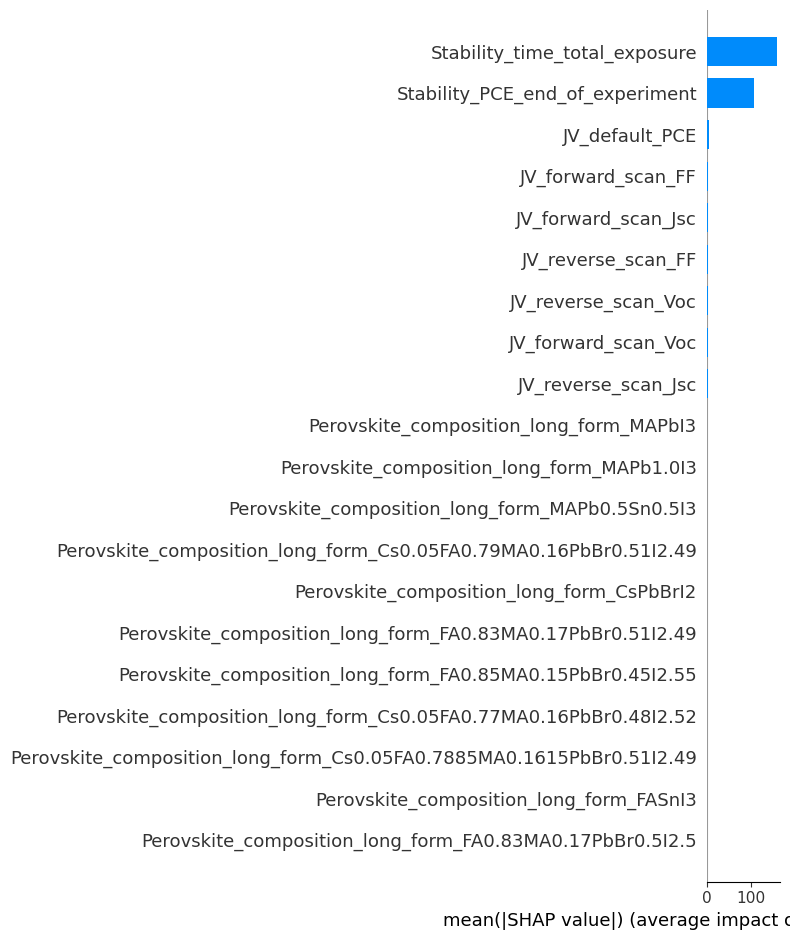

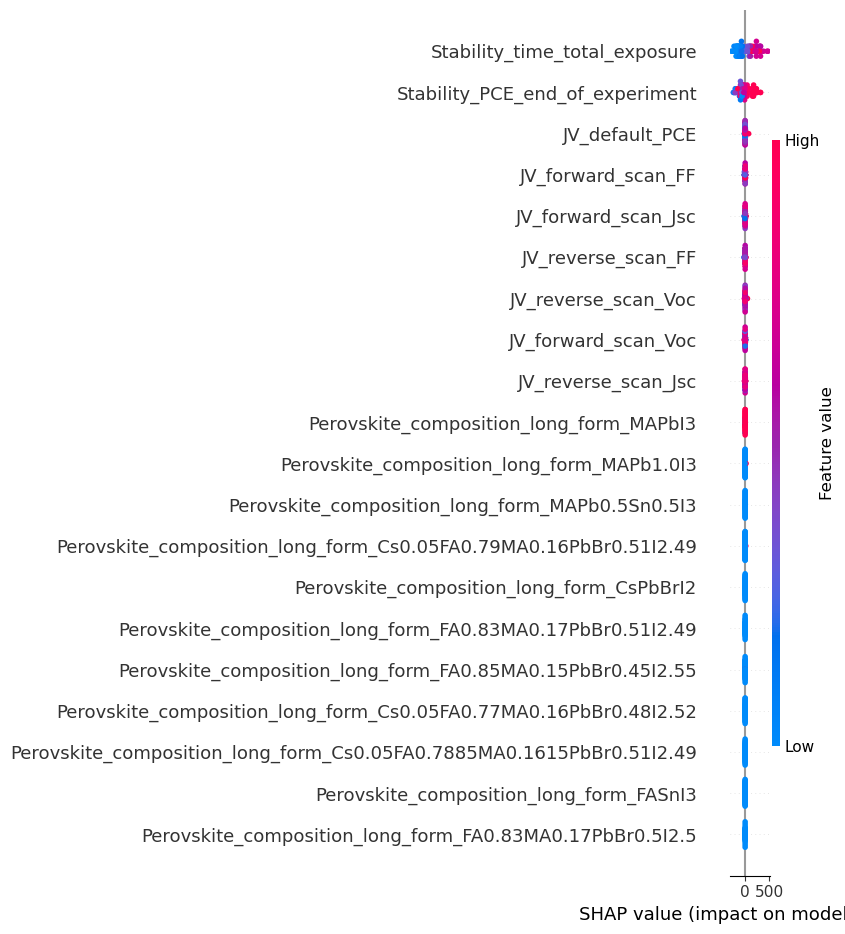

In [97]:
import matplotlib.pyplot as plt
# Summary plot (beeswarm) for top contributing features
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_sample, plot_type='bar')
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_sample)
